# Load all packages that we need

This is based on the following example: 

https://qcodes.github.io/Qcodes/examples/driver_examples/Qcodes%20example%20with%20AMI430.html

In [1]:
import time 
import numpy as np 
import matplotlib.pyplot as plt
from qcodes.instrument_drivers.american_magnetics.AMI430_visa import AMI430, AMI430_3D
from qcodes.math_utils.field_vector import FieldVector

# Check if we can establish communication with the power sources


The easiest way to find the TCPIP adresses of the magnet is to use the Multi-Axis Operation module from AMI. 

Open: Define Parameter/Limits to find the respective information. Port 76180 seems to be universal. 

Only run the cell below once, otherwise it will crash. 

In [2]:
ix = AMI430("x", address="TCPIP0::169.254.27.8::7180::SOCKET")
iy = AMI430("y", address="TCPIP0::169.254.70.51::7180::SOCKET")
iz = AMI430("z", address="TCPIP0::169.254.201.182::7180::SOCKET")

Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-054, firmware:3.15) in 1.21s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-053, firmware:3.15) in 1.35s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:430-22-055, firmware:3.15) in 1.20s


# Testing the single axis example of the driver:

In [3]:
instrument = iz 

# Get the instrument id 
instrument_id = instrument.get_idn()
print(instrument_id)


{'vendor': 'AMERICAN MAGNETICS INC.', 'model': '430', 'serial': '430-22-055', 'firmware': '3.15'}


## Getting all the settings form the programmer
### Getting single values

In [4]:
instrument.coil_constant.get()

0.0968

In [5]:
instrument.coil_constant.unit

'T/A'

### Iterating over all instrument settings:

In [6]:
params = instrument.parameters
for p in params: 
    print(params[p] ,params[p].get(), params[p].unit)

z_IDN {'vendor': 'AMERICAN MAGNETICS INC.', 'model': '430', 'serial': '430-22-055', 'firmware': '3.15'} 
z_timeout 5.0 s
z_ramp_rate_units seconds 
z_field_units tesla 
z_current_ramp_limit 0.06 A/s
z_field_ramp_limit 0.005808 T/s
z_coil_constant 0.0968 T/A
z_current_limit 61.98 A
z_field_limit 5.999663999999999 T
z_field -4.1199e-05 T
z_ramp_rate 0.005 T/s
z_setpoint 0.0 T
z_is_quenched False 
z_ramping_state paused 
z_ramping_state_check_interval 0.05 s


### See the fluctations in the z-field as a function of time:

In [7]:
start_time = time.time()
trace_length = 61

t = np.linspace(0,trace_length,trace_length)
B_z = np.zeros(trace_length)
for i in range(trace_length):
    time.sleep(1 - time.monotonic() % 1)
    B_z[i] = instrument.field.get()
    

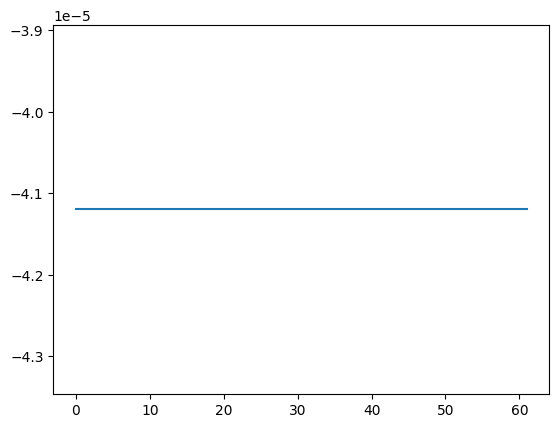

In [8]:
plt.figure()
plt.plot(t,B_z)


## Writing settings to the prorgrammer: 

We try to set a new ramp rate limit and check what happens

In [63]:
instrument.ramp_rate.set(0.001)
instrument.ramp_rate.get()

0.001

### Understanding the connections of all the constants we set: 

The data from the Datasheet of the Magnet gives the following constrictions for the z-Axis instrument. 

1. Maximal Field, 60kG = 6 T
2. Rated operating Current  61.98 A
3. Ramp Rate  0.0909 A/s
4. Field to Current Ratio 0.9680 kG/Amp = 0.09680 T/A (Maximal Field/Rated Operating Current) -- Actually obsolet number
5. Inductance 11 H
6. Recommended Persisten Switch Heater Current 20.1mA
7. Persistent Switch Heater Nominal Resistance 168 Ohm @ RT 
8. Total Magnet and Switch Resistance 36 Ohm @ RT

Side note to myself: in the current settings the ramp rate limit was set to 0.06A/s which is 1/3 lower than the datasheet allows. I dont see why this is the case. 

In [65]:
params = instrument.parameters
for p in params: 
    print(params[p] ,params[p].get(), params[p].unit)

z_IDN {'vendor': 'AMERICAN MAGNETICS INC.', 'model': '430', 'serial': '430-22-055', 'firmware': '3.15'} 
z_timeout 5.0 s
z_ramp_rate_units seconds 
z_field_units tesla 
z_current_ramp_limit 0.06 A/s
z_field_ramp_limit 0.005808 T/s
z_coil_constant 0.0968 T/A
z_current_limit 61.98 A
z_field_limit 5.999663999999999 T
z_field -4.1199e-05 T
z_ramp_rate 0.001 T/s
z_setpoint 0.0 T
z_is_quenched False 
z_ramping_state paused 
z_ramping_state_check_interval 0.05 s


In [73]:
magnet_spec = {
    'current_limit': 61.98, # Ampere
    'field_limit' : 6, # Tesla
    'ramp_rate' : 0.0909, # Ampere/s
}
magnet_spec['coil_constant'] =magnet_spec['field_limit']/magnet_spec['current_limit']
magnet_spec['field_ramp_limit']=magnet_spec['coil_constant']*magnet_spec['ramp_rate']

In [75]:
print(magnet_spec)

{'current_limit': 61.98, 'field_limit': 6, 'ramp_rate': 0.0909, 'coil_constant': 0.0968054211035818, 'field_ramp_limit': 0.008799612778315586}


In [78]:
instrument.field_ramp_limit.set(magnet_spec['field_ramp_limit'])
instrument.field_ramp_limit.get()

0.008799612778315586

In [86]:
params = instrument.parameters
for p in params: 
    print(params[p] ,params[p].get(), params[p].unit)

z_IDN {'vendor': 'AMERICAN MAGNETICS INC.', 'model': '430', 'serial': '430-22-055', 'firmware': '3.15'} 
z_timeout 5.0 s
z_ramp_rate_units seconds 
z_field_units tesla 
z_current_ramp_limit 0.09090509068507838 A/s
z_field_ramp_limit 0.008799612778315586 T/s
z_coil_constant 0.0968 T/A
z_current_limit 61.98 A
z_field_limit 5.999663999999999 T
z_field -4.1199e-05 T
z_ramp_rate 0.005 T/s
z_setpoint 0.0 T
z_is_quenched False 
z_ramping_state paused 
z_ramping_state_check_interval 0.05 s


# List of Questions for Hans:

- In my understanding the logic of the example of qcodes and the current code is not the same. It seems to me that qcodes has hidden variables for coil_constant which is no longer the case. 

- Labber logic. How is a sweep generated in Labber? 
Example: The user sets up a sweep from (0,0,0)T to (2,2,2)T. We know that points out of (1,1,1) are not allowed due to limits of the maximum field. Is labber now communicating on a point to point basis with the driver and we check every point before we set it. This would lead to an error message once we reach (1,1,1). Or do we get the full sweep information before the measurement starts and we would stop the measurement from happening at all ? 

# Use Cases of the Magnet: 

- Individual sweeps of magnet axis with defined ramp rate. The ramp rate should always be below the maximum allowed ramp rate. 

- Block user from continuing measuring after a quench has happend. Meaning that we do not switch the Powersupply back to remote control mode. 

- After every restart of the driver check that the correct Magnet Information values are uploaded to the device. 

- Turn on/off heat switch, turn on off current on the axis with the heat switch

- We know that the magnetic field is not completely stable when the magnet is operated with the switch heater in the sc state. We do want the option to keep the powersuplly current on while the heatswitch is in the superconducting state 

- We want the following sweep modes 
    - 1d sweeps 
    - 2d/3d sweeps where we sweep each axis individually to achieve maximum speed. Check if all measurement points are within the allowed magnetic field range.
    - 2d/3d zylindrical/spherical sweeps along a trajectory with constant r. In this case the sweeprate that is maximally allowed needs to be reduced to a given parameter.


# List of ToDos Benedikt:

- Understand the meaning of the scaling factor in the ramp rate settings. 
- Understand 2d/3d driver initialitations. 
- How does quench protection work on AMI systems 
- Check stability of the Magnetic field. How fast do we reach a defined setpoint and how stable are we there. 
- Cann switch heater supraleitend sein waehren wir die xy achse sweepen

